In [1378]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

## 1. Data exploration

In [1379]:
df_dev = pd.read_csv('/Users/fabiodepetro/DSL_Project/ProvaProgetto/DSL_Winter_Project_2025/development.csv')
df_eval = pd.read_csv('/Users/fabiodepetro/DSL_Project/ProvaProgetto/DSL_Winter_Project_2025/evaluation.csv')

In [1380]:
df = pd.concat([df_dev, df_eval], sort=False)
len(df_dev), len(df_eval), len(df)

(2933, 691, 3624)

In [1381]:
df.isna().sum().sum() 

691

only the 'age' values on the evaluation dataframe are NaN so there are no NaN to handle

In [1382]:
df.head()

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
0,0,22050,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893,audios_development/1.wav
1,1,22050,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662,audios_development/2.wav
2,2,22050,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998,audios_development/3.wav
3,3,22050,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127,audios_development/4.wav
4,4,22050,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905,audios_development/5.wav


In [1383]:
df.columns

Index(['Id', 'sampling_rate', 'age', 'gender', 'ethnicity', 'mean_pitch',
       'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path'],
      dtype='object')

In [1384]:
def extract_6_digits(s):
  s = s.replace('[', "") 
  parts = s.split('.')
  decimale = parts[1][:6] 
  return float(parts[0] + '.' + decimale)


df['tempo'] = df['tempo'].apply(extract_6_digits)
df['tempo'] = pd.to_numeric(df['tempo'])
df['tempo'] = df['tempo'] / 60 # convert in beats per second

There are 2 categorical columns = ['gender','ethnicity'] that we need to convert them in numerical values if we want to use them in the regression task.

In [1385]:
df_1h_gender = pd.get_dummies(df, columns=['gender'])
df_1h_gender.columns

Index(['Id', 'sampling_rate', 'age', 'ethnicity', 'mean_pitch', 'max_pitch',
       'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path', 'gender_famale',
       'gender_female', 'gender_male'],
      dtype='object')

There is 1 row that has 'famale' instead of having 'female' so we have to correct it.

In [1386]:
df[df['gender'] == 'famale']

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration,path
454,454,22050,NaN,famale,taiwanese,1051.0619,3997.4036,145.44014,0.022114,0.084117,0.003421,0.106298,2073.085801,2.533318,-108.084637,69,281,46,29.466122,audios_evaluation/455.wav


Listening the audio in evaluation/455.wav we found this is a female so we put 'female' instead of 'famale'

In [1387]:
df.loc[(df['gender']!='male') & (df['gender'] != 'female'), 'gender'] = 'female'
df_1h_gender = pd.get_dummies(df, columns=['gender'])

In [1388]:
df_1h_gender.columns

Index(['Id', 'sampling_rate', 'age', 'ethnicity', 'mean_pitch', 'max_pitch',
       'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path', 'gender_female',
       'gender_male'],
      dtype='object')

Now we go to see how many ethnicities there are in the dataset and how are the distributions of those.

In [1389]:
df['ethnicity'].value_counts()

ethnicity
igbo         1313
english       579
spanish       162
arabic        102
mandarin       65
             ... 
lamaholot       1
gedeo           1
sa'a            1
frisian         1
sundanese       1
Name: count, Length: 221, dtype: int64

In [1390]:
df['ethnicity'].value_counts(normalize=True)

ethnicity
igbo         0.362307
english      0.159768
spanish      0.044702
arabic       0.028146
mandarin     0.017936
               ...   
lamaholot    0.000276
gedeo        0.000276
sa'a         0.000276
frisian      0.000276
sundanese    0.000276
Name: proportion, Length: 221, dtype: float64

In [1391]:
ethnicity_count = df['ethnicity'].value_counts()
ethnicity_count.values

array([1313,  579,  162,  102,   65,   63,   52,   48,   48,   47,   37,
         36,   34,   33,   33,   29,   27,   26,   26,   23,   23,   22,
         20,   20,   20,   18,   18,   18,   18,   17,   17,   16,   15,
         15,   14,   13,   12,   11,   11,   10,   10,   10,   10,   10,
          9,    9,    9,    9,    9,    9,    9,    9,    8,    8,    8,
          8,    8,    8,    8,    7,    6,    6,    6,    6,    6,    6,
          6,    6,    5,    5,    5,    5,    5,    5,    5,    5,    4,
          4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,   

The dataset is highly unbalanced on the ethnicity distributions because there are a lot of ethnicity with count = 1 and very few ethnicities have a cardinality > 50.

There are 221 ethnicities that means that we'll have 221 columns to add to the ones that we have now. 
We think it's useless to one hot encode all these columns and we decide to keep and encode only the ethnicities which have more than 50 of cardinality and group the others in 'Other' encode.

In [1396]:
def one_hot_encode_ethnicity(df, ethnicity_column='ethnicity', threshold=50):
  ethnicity_counts = df[ethnicity_column].value_counts()
  rare_ethnicities = ethnicity_counts[ethnicity_counts < threshold].index
  df[ethnicity_column] = df[ethnicity_column].replace(rare_ethnicities, 'Other')
  df = pd.get_dummies(df, columns=[ethnicity_column], prefix=ethnicity_column)

  return df
df_1h = one_hot_encode_ethnicity(df_1h_gender)

In [1400]:
columns_to_drop = ['Id', 'sampling_rate', 'path'] # useless for the model


In [1401]:
df_dropped = df_1h.drop(columns=columns_to_drop)

Testing a random forest on these features for see the 1st RMSE try.

In [1402]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

train_valid_mask = ~df_dropped['age'].isna()

X = df_dropped.drop(columns=['age']).values
y = df_dropped['age'].values


X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask]


X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_valid)

print(root_mean_squared_error(y_valid, y_pred))

10.067472919659378


In [1403]:
print(cross_val_score(reg, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error'))
print(np.mean(cross_val_score(reg, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

[ -9.26951462 -10.52463224 -11.03000535 -12.5464358  -10.13193274]
-10.700504148791712


Let's think about manipulate the audios we have and use them for extract some other features

## 2. Feature Extraction

In [1493]:
import pandas as pd
path_df = '../datasets/df_features_extracted.csv'
df = pd.read_csv(path_df)

Application of the preprocessing step for the raw df with the feature extracted

In [1494]:
df['tempo'] = df['tempo'].apply(extract_6_digits)
df['tempo'] = pd.to_numeric(df['tempo'])
df['tempo'] = df['tempo'] / 60

In [1495]:
df.loc[(df['gender']!='male') & (df['gender'] != 'female'), 'gender'] = 'female'
df_1h = pd.get_dummies(df, columns=['gender'])

In [1496]:
def one_hot_encode_ethnicity(df, ethnicity_column='ethnicity', threshold=50):
  ethnicity_counts = df[ethnicity_column].value_counts()
  rare_ethnicities = ethnicity_counts[ethnicity_counts < threshold].index
  df[ethnicity_column] = df[ethnicity_column].replace(rare_ethnicities, 'Other')
  df = pd.get_dummies(df, columns=[ethnicity_column], prefix=ethnicity_column)

  return df
df_1h = one_hot_encode_ethnicity(df_1h)

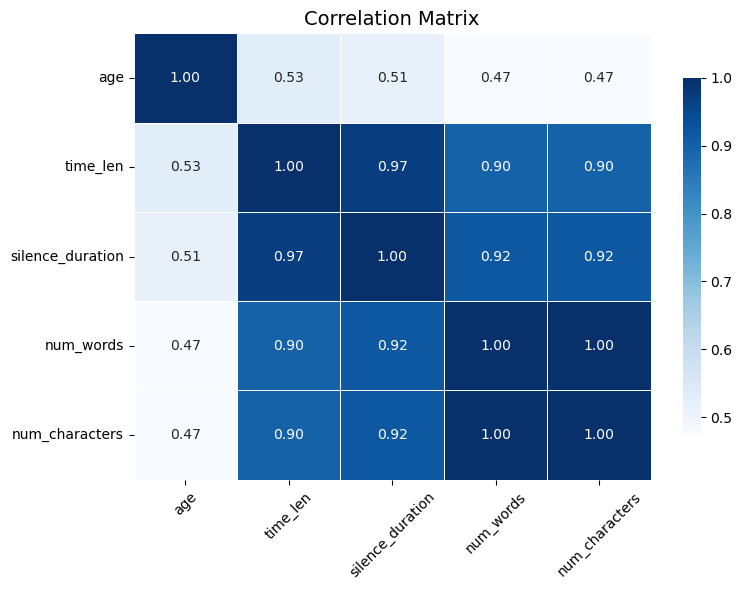

In [1497]:
import seaborn as sns
correlation_matrix = df[['age', 'time_len', 'silence_duration','num_words', 'num_characters']].corr()

# Creazione della heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, 
            annot=True,  
            cmap='Blues',  
            fmt=".2f",  
            linewidths=0.5,  
            cbar_kws={"shrink": 0.8})  

plt.title('Correlation Matrix', fontsize=14)
plt.xticks(fontsize=10, rotation=45) 
plt.yticks(fontsize=10, rotation=0)   
plt.tight_layout()

plt.savefig("correlation_matrix.pdf", dpi=300, bbox_inches='tight')  # Immagine ad alta risoluzione
plt.show()

In [1551]:
df['age'][~df['age'].isna()].median()

23.0

In [1552]:
df['age'][~df['age'].isna()].std()

13.093315610440829

In [1553]:
df['age'][~df['age'].isna()].mean()

27.897886123423117

We decide to discard num_words, num_characters and silence_duration and keep time_len

In [1498]:
columns_to_drop = ['Id', 'sampling_rate', 'path', 'num_words', 'num_characters', 'silence_duration']

In [1499]:
df_dropped = df_1h.drop(columns=columns_to_drop)

## 3. Feature selection

In [1500]:
X = df_dropped.drop(columns=['age'])
y = df_dropped['age']

train_valid_mask = ~df_dropped['age'].isna()
feature_names = df_dropped.drop(columns='age').columns

X_train_valid = X[train_valid_mask] # dev 
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask] # evaluation

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, shuffle=True)

reg = RandomForestRegressor(random_state = 42, n_estimators=100)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_valid)
rmse_valid = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE sul set di validation (senza outliers): {rmse_valid}")

RMSE sul set di validation (senza outliers): 9.705996173092972


In [1501]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(reg, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

-10.13863053101376


'Important features' is the baseline where we add more features and try to reduce the rmse

In [1502]:
sorted_features = sorted(zip(feature_names, reg.feature_importances_), key = lambda x : x[1], reverse=True)

important_features = [feature for feature, importance in sorted_features if importance > 0.009]

In [1503]:
important_features

['time_len',
 'ethnicity_english',
 'Chroma7_median',
 'MFCC10_std',
 'jitter',
 'Chroma6_median',
 'Chroma12_std',
 'spectral_centroid_mean_x',
 'MFCC7_median',
 'Chroma6_std',
 'MFCC6_mean',
 'shimmer']

There is ethnicity english so we decide to reintroduce all the ethnicities to prevent overfitting.

In [1504]:
important_features = important_features + ['ethnicity_igbo', 'ethnicity_spanish', 'ethnicity_arabic', 'ethnicity_korean', 'ethnicity_mandarin', 'ethnicity_french', 'ethnicity_Other']

Then we retry the cross val score using the important features

In [1505]:
X = df_dropped.drop(columns=['age'])[important_features]
y = df_dropped['age']

feature_names = df_dropped.drop(columns='age').columns

X_train_valid = X[train_valid_mask] # dev 
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask] # evaluation

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, shuffle=True)

reg = RandomForestRegressor(random_state = 42, n_estimators=100)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_valid)
rmse_valid = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE sul set di validation : {rmse_valid}")

RMSE sul set di validation : 9.508134585523203


In [1506]:
print(np.mean(cross_val_score(reg, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

-9.88588796949413


Let's find some columns which have low correlation with the features that are in the important features and an high correlation with the target variable and try some combinations of those features for reduce the rmse.

In [1507]:
def find_top_features(df, important_features, max_correlation_with_important, first_n=10):
  corr_matrix = df.corr()

  target_corr = np.abs(corr_matrix['age'].drop('age'))  
  
  candidate_features = target_corr.drop(index=important_features, errors='ignore')
  
  low_corr_candidates = []
  for feature in candidate_features.index:
    if all(abs(corr_matrix.loc[feature, imp_feature]) < max_correlation_with_important 
        for imp_feature in important_features if imp_feature in corr_matrix):
      low_corr_candidates.append(feature)
  
  filtered_features = target_corr.loc[low_corr_candidates].sort_values(ascending=False).head(first_n)
  
  return filtered_features

top_features = find_top_features(df_dropped, important_features=important_features, max_correlation_with_important=0.7, first_n=10)

print(top_features)


time_skew       0.337295
time_max        0.328943
mean_pitch      0.315645
MFCC2_mean      0.315057
MFCC5_std       0.313383
MFCC1_std       0.311292
MFCC2_std       0.284386
MFCC8_std       0.270458
MFCC2_median    0.270423
MFCC10_mean     0.260298
Name: age, dtype: float64


Here we can decide how to go on and trying these features (first 4 on the matrix)

In [1508]:
important_features = important_features + ['time_skew', 'time_max', 'mean_pitch', 'MFCC2_mean']

In [1509]:
def find_top_features(df, important_features, max_correlation_with_important, first_n):
  corr_matrix = df.corr()
  
  target_corr = np.abs(corr_matrix['age'].drop('age'))
  
  candidate_features = target_corr.drop(index=important_features, errors='ignore')
  low_corr_candidates = []
  for feature in candidate_features.index:
    if all(abs(corr_matrix.loc[feature, imp_feature]) < max_correlation_with_important 
       for imp_feature in important_features if imp_feature in corr_matrix):
      low_corr_candidates.append(feature)
  
  filtered_features = target_corr.loc[low_corr_candidates].sort_values(ascending=False).head(first_n)
  
  return filtered_features

top_features = find_top_features(df_dropped, important_features=important_features, max_correlation_with_important=0.7, first_n=10)


print(top_features)


MFCC5_std        0.313383
MFCC1_std        0.311292
MFCC2_std        0.284386
MFCC8_std        0.270458
MFCC10_mean      0.260298
MFCC13_std       0.258573
MFCC12_median    0.252299
MFCC12_mean      0.251471
Chroma4_std      0.250014
MFCC10_median    0.249804
Name: age, dtype: float64


In [1510]:
X = df_dropped.drop(columns=['age'])[important_features]
y = df_dropped['age']

feature_names = df_dropped.drop(columns='age').columns

X_train_valid = X[train_valid_mask] # dev 
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask] # evaluation

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, shuffle=True)

reg = RandomForestRegressor(random_state = 42, n_estimators=100)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_valid)
rmse_valid = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE sul set di validation : {rmse_valid}")

RMSE sul set di validation : 9.51398358671305


In [1511]:
print(np.mean(cross_val_score(reg, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

-9.734374258367822


Here we can decide to iterate the process and add more features based on the correlation with the target variable and with the others in the important features.
For now we decide to keep these and select these as the best features.

In [1512]:
best_features = important_features 

In [1513]:
len(best_features)

23

In [1514]:
best_features

['time_len',
 'ethnicity_english',
 'Chroma7_median',
 'MFCC10_std',
 'jitter',
 'Chroma6_median',
 'Chroma12_std',
 'spectral_centroid_mean_x',
 'MFCC7_median',
 'Chroma6_std',
 'MFCC6_mean',
 'shimmer',
 'ethnicity_igbo',
 'ethnicity_spanish',
 'ethnicity_arabic',
 'ethnicity_korean',
 'ethnicity_mandarin',
 'ethnicity_french',
 'ethnicity_Other',
 'time_skew',
 'time_max',
 'mean_pitch',
 'MFCC2_mean']

## 4. Grid search on the random forest hyperparameters

### 1. Random forest regressor

In [1515]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [500],  
#     'max_depth': [10, 20, 30],     
#     'min_samples_split': [2, 5, 6],          
#     'min_samples_leaf': [2, 3, 4, 5],             
#     'max_features': ['sqrt', 'log2'],  
#     'random_state' : [42]
# }

# grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f"Migliori parametri: {grid_search.best_params_}")

In [1516]:
# best_random_forest = grid_search.best_estimator_
# best_random_forest.fit(X_train, y_train)
# y_predicted = best_random_forest.predict(X_valid)

In [1517]:
# print(np.abs(np.mean(cross_val_score(best_random_forest, X_valid, y_valid, cv=5, scoring = 'neg_root_mean_squared_error)))
# print(np.abs(cross_val_score(best_random_forest, X_valid, y_valid, cv=5, scoring = 'neg_root_mean_squared_error)))

In [1518]:
# best_random_forest.fit(X_train_valid, y_train_valid)
# y_predicted = best_random_forest.predict(X_test)

We runned the grid_search one time and then saved the model in the 'models' directory, so we just need to load that.

In [1519]:
import pickle

def load_model(filename):
  with open(filename, 'rb') as file:
    model = pickle.load(file)
  print(f"Modello caricato da {filename}")
  return model

filename = '../models/best_random_forest.pkl'
best_random_forest = load_model(filename)

Modello caricato da ../models/best_random_forest.pkl


In [1520]:
best_random_forest.fit(X_train, y_train)
y_predicted = best_random_forest.predict(X_valid)

In [1521]:
print(cross_val_score(best_random_forest, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error'))
print(np.abs(np.mean(cross_val_score(best_random_forest, X_valid, y_valid, cv=5, scoring='neg_root_mean_squared_error'))))

[ -8.26483745  -9.16861336 -10.13672973 -11.76098489  -8.91969295]
9.650171675502378


In [1522]:
best_random_forest.fit(X_train_valid, y_train_valid)
y_predicted = best_random_forest.predict(X_test)

In [1523]:
# pd.DataFrame(y_predicted, index=df_eval.index).to_csv("../final_random_forest_FINALE.csv",
#                                                         index_label="Id", header=["Predicted"])

In [1524]:
sorted(zip(best_features, best_random_forest.feature_importances_), key= lambda x : x[1], reverse=True)

[('time_len', 0.18126286080087275),
 ('time_skew', 0.07444441762282912),
 ('MFCC7_median', 0.06881611348638564),
 ('time_max', 0.058047083664812704),
 ('mean_pitch', 0.05781018415611342),
 ('ethnicity_igbo', 0.05367700809083466),
 ('jitter', 0.05273177523835021),
 ('MFCC2_mean', 0.051903827531298546),
 ('Chroma7_median', 0.05077618238147136),
 ('MFCC6_mean', 0.04988042946405828),
 ('Chroma6_median', 0.04971965301541469),
 ('spectral_centroid_mean_x', 0.04361982073713578),
 ('shimmer', 0.043129527726245766),
 ('MFCC10_std', 0.04279827344477933),
 ('Chroma6_std', 0.04071670889916952),
 ('Chroma12_std', 0.038876690296919175),
 ('ethnicity_english', 0.02896342784621796),
 ('ethnicity_Other', 0.007535926288657297),
 ('ethnicity_arabic', 0.002266521589881349),
 ('ethnicity_french', 0.0015478950129115508),
 ('ethnicity_korean', 0.0008073527838056419),
 ('ethnicity_mandarin', 0.0006683199218354084),
 ('ethnicity_spanish', 0.0)]

Save random forest in the 'models' directory

In [1526]:

# import pickle

# with open('../models/best_random_forest.pkl', 'wb') as file:
#     pickle.dump(best_random_forest, file)

# print("Modello salvato come 'best_random_forest.pkl'")


### 2. Support vector regressor (SVR)

The Support Vector Regressor (SVR) requires standardized data for optimal performance, as it is sensitive to the scale of the input features. Without standardization, features with larger ranges could dominate the model, leading to suboptimal results.

In [1527]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

rf = SVR()

rf.fit(X_train_scaled, y_train)
y_predicted = rf.predict(X_valid_scaled)

rmse = root_mean_squared_error(y_valid, y_predicted)
print(f"RMSE sul validation set: {rmse:.4f}")

RMSE sul validation set: 10.4406


In [1528]:
print(cross_val_score(rf, X_valid_scaled, y_valid, cv=5, scoring='neg_root_mean_squared_error'))
print(np.mean(cross_val_score(rf, X_valid_scaled, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

[ -9.22498249 -11.46612384 -11.16752062 -12.97807862 -11.41157328]
-11.249655767711666


In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'kernel': ['linear', 'rbf', 'poly'],      
#      'C': [0.1, 1, 5, 50, 100],                   
#      'epsilon': [0.01, 0.1, 1, 5, 10],                
#      'gamma': ['scale', 'auto', 0.1, 0.01]     
#  }

 
# grid_search_svr = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_root_mean_squared_error', 
#                              cv=5, n_jobs=-1)
# grid_search_svr.fit(X_train_scaled, y_train)

# # 
# best_params = grid_search_svr.best_params_
# best_svr = grid_search_svr.best_estimator_


# y_pred = best_svr.predict(X_valid_scaled)
# best_rmse = root_mean_squared_error(y_valid, y_pred)
# best_rmse

In [ ]:
# import pickle

# with open('../models/best_svr.pkl', 'wb') as file:
#  pickle.dump(best_svr, file)

# print("Modello salvato come 'best_svr.pkl'")

In [ ]:
# scaler_train_valid = StandardScaler()
# X_train_valid_scaled = scaler_train_valid.fit_transform(X_train_valid)
# X_test_scaled = scaler.transform(X_test)

In [1530]:
import pickle

def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Modello caricato da {filename}")
    return model

# Esempio di utilizzo
filename = '../models/best_svr.pkl'
best_svr = load_model(filename)

Modello caricato da ../models/best_svr.pkl


In [1531]:
best_svr.fit(X_train_scaled, y_train)
root_mean_squared_error(y_valid, best_svr.predict(X_valid))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


13.71879189833424

In [1532]:
print(cross_val_score(best_svr, X_valid_scaled, y_valid, cv=5, scoring='neg_root_mean_squared_error'))
print(np.mean(cross_val_score(best_svr, X_valid_scaled, y_valid, cv=5, scoring='neg_root_mean_squared_error')))

[ -8.65038005  -9.42862666 -10.22438377 -11.59504683  -9.03818701]
-9.78732486628989


In [1533]:
scaler_train_valid = StandardScaler()
X_train_valid_scaled = scaler_train_valid.fit_transform(X_train_valid)
X_test_scaled = scaler.transform(X_test)

In [1534]:
best_svr.fit(X_train_valid_scaled, y_train_valid)
y_predicted = best_svr.predict(X_test_scaled)

In [1535]:
pd.DataFrame(y_predicted, index=df_eval.index).to_csv("../submissions/final_svr_FINALE.csv",
                                                        index_label="Id", header=["Predicted"])

In [1536]:
sorted(zip(best_features, reg.feature_importances_), key= lambda x : x[1], reverse=True)

[('time_len', 0.3385906009858684),
 ('Chroma7_median', 0.05848141464865486),
 ('MFCC6_mean', 0.050934242750108494),
 ('MFCC7_median', 0.04862944851923322),
 ('MFCC10_std', 0.04777174535779924),
 ('jitter', 0.04600474637037938),
 ('Chroma12_std', 0.04540861838700852),
 ('ethnicity_english', 0.04317571336291215),
 ('Chroma6_median', 0.04170779971211331),
 ('MFCC2_mean', 0.04149108434211958),
 ('spectral_centroid_mean_x', 0.04130988222347377),
 ('Chroma6_std', 0.04110248857614554),
 ('time_skew', 0.038608817947152214),
 ('mean_pitch', 0.03828550863056906),
 ('shimmer', 0.036339998791329486),
 ('time_max', 0.03355861653902973),
 ('ethnicity_Other', 0.003889886273340308),
 ('ethnicity_french', 0.0014745186588877234),
 ('ethnicity_korean', 0.0012030829402580048),
 ('ethnicity_arabic', 0.0009512097865767499),
 ('ethnicity_mandarin', 0.0007033782360920085),
 ('ethnicity_igbo', 0.0003771969609483192),
 ('ethnicity_spanish', 0.0)]

## 5. Naive solution

In [1537]:
df_dev = pd.read_csv('/Users/fabiodepetro/DSL_Project/ProvaProgetto/DSL_Winter_Project_2025/development.csv')
df_eval = pd.read_csv('/Users/fabiodepetro/DSL_Project/ProvaProgetto/DSL_Winter_Project_2025/evaluation.csv')

In [1538]:
df_naive_sol = pd.concat([df_dev, df_eval], axis=0)

In [1539]:
def extract_6_digits(s):
  s = s.replace('[', "") 
  parts = s.split('.')
  decimale = parts[1][:6] 
  return float(parts[0] + '.' + decimale)


df_naive_sol['tempo'] = df_naive_sol['tempo'].apply(extract_6_digits)
df_naive_sol['tempo'] = pd.to_numeric(df['tempo'])
df_naive_sol['tempo'] = df_naive_sol['tempo'] / 60 # convert in beats per second

In [1540]:
df_naive_sol.loc[(df_naive_sol['gender']!='male') & (df_naive_sol['gender'] != 'female'), 'gender'] = 'female'
df_naive_sol_1h_gender = pd.get_dummies(df_naive_sol, columns=['gender'])

In [1541]:
df_naive_sol_1h = pd.get_dummies(df_naive_sol_1h_gender, columns=['ethnicity'])

In [1542]:
df_dropped_naive_sol = df_naive_sol_1h.drop(columns=['Id', 'sampling_rate', 'path'])

In [1543]:
X.shape

(3624, 23)

In [1544]:
train_valid_mask_naive_sol = ~df_dropped_naive_sol['age'].isna()

X = df_dropped_naive_sol.drop(columns=['age']).values
y = df_dropped_naive_sol['age'].values


feature_names = df_dropped_naive_sol.drop(columns='age').columns

X_train_valid_naive_sol = X[train_valid_mask_naive_sol] # dev 
y_train_valid_naive_sol = y[train_valid_mask_naive_sol]

X_test_naive_sol = X[~train_valid_mask_naive_sol]
# Divisione train e valid
X_train_naive_sol, X_valid_naive_sol, y_train_naive_sol, y_valid_naive_sol = train_test_split(X_train_valid_naive_sol, y_train_valid_naive_sol, test_size=0.2, random_state=42, shuffle=True)

# Training del modello
reg = RandomForestRegressor(random_state = 42, n_estimators=100)
reg.fit(X_train_naive_sol, y_train_naive_sol)

y_pred = reg.predict(X_valid_naive_sol)
rmse_valid = root_mean_squared_error(y_valid_naive_sol, y_pred)
print(f"RMSE sul set di validation : {rmse_valid}")

RMSE sul set di validation : 10.004722298538267


In [1545]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

train_valid_mask = ~df_dropped['age'].isna()

X = df_dropped.drop(columns=['age']).values
y = df_dropped['age'].values


X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]

X_test = X[~train_valid_mask]


X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_valid)

print(root_mean_squared_error(y_valid, y_pred))

9.705996173092972


In [1546]:
print(cross_val_score(reg, X_valid_naive_sol, y_valid_naive_sol, cv=5, scoring='neg_root_mean_squared_error'))
print(np.mean(cross_val_score(reg, X_valid_naive_sol, y_valid_naive_sol, cv=5, scoring='neg_root_mean_squared_error')))

[ -9.27101299 -10.56764763 -11.06023312 -12.53674391 -10.0434235 ]
-10.69581222874536


In [1547]:
# reg.fit(X_train_valid_naive_sol, y_train_valid_naive_sol)
# y_predicted_naive_sol = reg.predict(X_test_naive_sol)
# pd.DataFrame(y_predicted_naive_sol, index=df_eval.index).to_csv("../submissions/naive_solution.csv",
#                                                        index_label="Id", header=["Predicted"])